In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import dask
import dask.array as da
from dask.diagnostics import ProgressBar
import glob
import matplotlib.pyplot as plt

import linearsim as ls
import seaborn as sns

# Sample a latin hypercube over the multivariate distribution

## Load the data

In [2]:
suffix = '_percentiles_221112' # Tag to added to output filename
n_seed = 10000
files = sorted(glob.glob(f'data/timeseries_stats/RAS_n{n_seed}{suffix}_*.nc'))
display(files[0:5])
print(f'Number of files {len(files)}')

['data/timeseries_stats\\RAS_n10000_percentiles_221112_00000.nc',
 'data/timeseries_stats\\RAS_n10000_percentiles_221112_00001.nc',
 'data/timeseries_stats\\RAS_n10000_percentiles_221112_00002.nc',
 'data/timeseries_stats\\RAS_n10000_percentiles_221112_00003.nc',
 'data/timeseries_stats\\RAS_n10000_percentiles_221112_00004.nc']

Number of files 1000


In [3]:
with dask.config.set(scheduler='processes'):
    with ProgressBar():
        print('Building dataset...')
        ds = xr.open_mfdataset(files,
                                concat_dim='seed',
                                combine='nested',
                                coords='minimal',
                                compat='override',
                                join='override',
                                parallel=True)

hyper_variables = ['this_seed','r_sample','Tz','Hmax','Hs']
ds = ds[hyper_variables]
with ProgressBar():
    print('Loading data...')
    ds = ds.load()

Building dataset...
[########################################] | 100% Completed | 8.62 ss
Loading data...
[########################################] | 100% Completed | 10.18 s


## Use scipy to generate a random sample on a Latin Hyper Cube

In [4]:
n_samples=7**2 # this needs to 
from scipy.stats import qmc
sampler = qmc.LatinHypercube(d=len(hyper_variables)-1,optimization='random-cd',strength=2)
sample = sampler.random(n=n_samples)
print(qmc.discrepancy(sample))

ds_lhc = xr.Dataset(pd.DataFrame(sample,columns=[f'{v}' for v in hyper_variables[1:]])).rename({'dim_0':'lhc'})
ds_lhc

0.0015317754039181342


<xarray.Dataset>
Dimensions:   (lhc: 49)
Coordinates:
  * lhc       (lhc) int64 0 1 2 3 4 5 6 7 8 9 ... 39 40 41 42 43 44 45 46 47 48
Data variables:
    r_sample  (lhc) float64 0.1319 0.4992 0.3933 0.2135 ... 0.8219 0.679 0.9647
    Tz        (lhc) float64 0.4176 0.02527 0.007478 ... 0.8646 0.989 0.9647
    Hmax      (lhc) float64 0.1076 0.2748 0.4176 0.7396 ... 0.5258 0.642 0.8219
    Hs        (lhc) float64 0.1319 0.2748 0.4176 0.5605 ... 0.3933 0.5361 0.679

### Identify seeds corresponding to the locations on the normalised (percentile) Latin Hyper Cube

In [5]:
def lhc_sample(ds,ds_lhc):
    """
    Function to recursively identify specific seeds at particular locations defined by a Latin Hyper Cube. The location of the samples are based on empirical CDFs of the variables in ds_lhc.

    The resulting seeds should be representative of the spread of the full multi-dimensional space.

    """
    def recursive_subsample(df,percentiles,lhc_n):
        this_v, this_pct = percentiles.pop()
        df_sorted = df.sort_values(this_v)

        if len(percentiles) > 0:
            loc = this_pct / (1 / lhc_n)
            dn = len(df_sorted) // lhc_n
            lower = int(np.floor(loc) * dn)
            upper = int(np.ceil(loc) * dn)
            df_subset = df_sorted.iloc[lower:upper,:]
            return recursive_subsample(df_subset,percentiles,lhc_n)
        else:
            idx = int(len(df) * this_pct)
            return int(df_sorted['this_seed'].values[idx])

    df = ds.drop(['gamma','n','fft_min_duration','dt','hs','tp']).to_dataframe()
    df_lhc = ds_lhc.to_dataframe()
    lhc_n = len(df_lhc)

    vv = list(df_lhc.columns)
    this_v = vv.pop()
    df_sorted = df.sort_values(this_v)
    df_lhc = df_lhc.sort_values(this_v)

    seeds = []

    this_pct = df_lhc[vv]
    dn = len(df_sorted) // lhc_n
    for n in range(lhc_n):
        lower = int(n * dn)
        upper = int((n+1) * dn)
        df_subset = df_sorted.iloc[lower:upper,:]
        percentiles = [(k,v) for k,v in this_pct.iloc[n].to_dict().items()]
        seeds.append(recursive_subsample(df_subset,percentiles,lhc_n)) 
    
    seeds = xr.DataArray(seeds,name='seeds',dims=['lhc'],coords={'lhc':df_lhc.index}).astype(int)
    return seeds

In [6]:
d_lhc_sample = dask.delayed(lhc_sample)

all_seeds = []
for g in ds.gamma:
    for n in ds.n:
        seeds = d_lhc_sample(ds.sel(gamma=g,n=n),ds_lhc)
        all_seeds.append(seeds.expand_dims({'gamma':[g,],'n':[n,]}))

with ProgressBar():
    results = dask.compute(all_seeds)[0]

ds_lhc_seeds = xr.merge([ds_lhc,] + results)
ds_lhc_seeds['seeds'] = ds_lhc_seeds['seeds'].astype(int)
ds_lhc_seeds = ds_lhc_seeds.assign_coords({k:ds[k] for k in ['fft_min_duration','dt','hs','tp']})
ds_lhc_seeds


[########################################] | 100% Completed | 34.77 s


<xarray.Dataset>
Dimensions:           (lhc: 49, gamma: 3, n: 6)
Coordinates:
  * lhc               (lhc) int64 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48
  * gamma             (gamma) float64 1.0 3.3 7.0
  * n                 (n) int32 10 20 50 100 250 500
    dt                float64 0.03125
    hs                float64 1.0
    tp                float64 1.0
    fft_min_duration  (n) int32 512 512 512 512 512 512
Data variables:
    r_sample          (lhc) float64 0.1319 0.4992 0.3933 ... 0.8219 0.679 0.9647
    Tz                (lhc) float64 0.4176 0.02527 0.007478 ... 0.989 0.9647
    Hmax              (lhc) float64 0.1076 0.2748 0.4176 ... 0.5258 0.642 0.8219
    Hs                (lhc) float64 0.1319 0.2748 0.4176 ... 0.3933 0.5361 0.679
    seeds             (gamma, n, lhc) int32 924842021 458337482 ... 105760542

## Calculate statistics from the wave timeseries with the returned seeds

In [7]:
seed_stats = ls.stats_from_seed(ds_lhc_seeds['seeds'])
seed_stats

<xarray.Dataset>
Dimensions:           (gamma: 3, n: 6, lhc: 49)
Coordinates:
    dt                float64 0.03125
    hs                float64 1.0
    tp                float64 1.0
  * gamma             (gamma) float64 1.0 3.3 7.0
  * n                 (n) int32 10 20 50 100 250 500
    fft_min_duration  (n) int32 512 512 512 512 512 512
  * lhc               (lhc) int64 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48
Data variables: (12/16)
    Tz                (gamma, n, lhc) float64 0.6735 0.5848 ... 0.8582 0.8573
    Tm01              (gamma, n, lhc) float64 0.7678 0.7748 ... 0.8821 0.8897
    Hm0               (gamma, n, lhc) float64 0.9776 1.013 0.977 ... 1.005 1.021
    Hs                (gamma, n, lhc) float64 0.8274 0.901 ... 1.002 1.014
    H13               (gamma, n, lhc) float64 0.7512 0.8145 ... 0.9693 1.005
    H13_unbiased      (gamma, n, lhc) float64 0.6792 0.7582 ... 0.9638 0.9989
    ...                ...
    r_spectra         (gamma, n, lhc) float64 0.672 0.6863 ... 0.8166 0.8255
    r_sample          (gamma, n, lhc) float64 0.02941 0.4246 ... 0.7124 0.764
    r_unbiased        (gamma, n, lhc) float64 -0.01384 0.2778 ... 0.6996 0.7494
    k3                (gamma, n, lhc) float64 -0.1595 -0.1655 ... 0.03559
    k4                (gamma, n, lhc) float64 -0.5903 -0.6372 ... 0.0521
    seed              (gamma, n, lhc) int32 924842021 458337482 ... 105760542

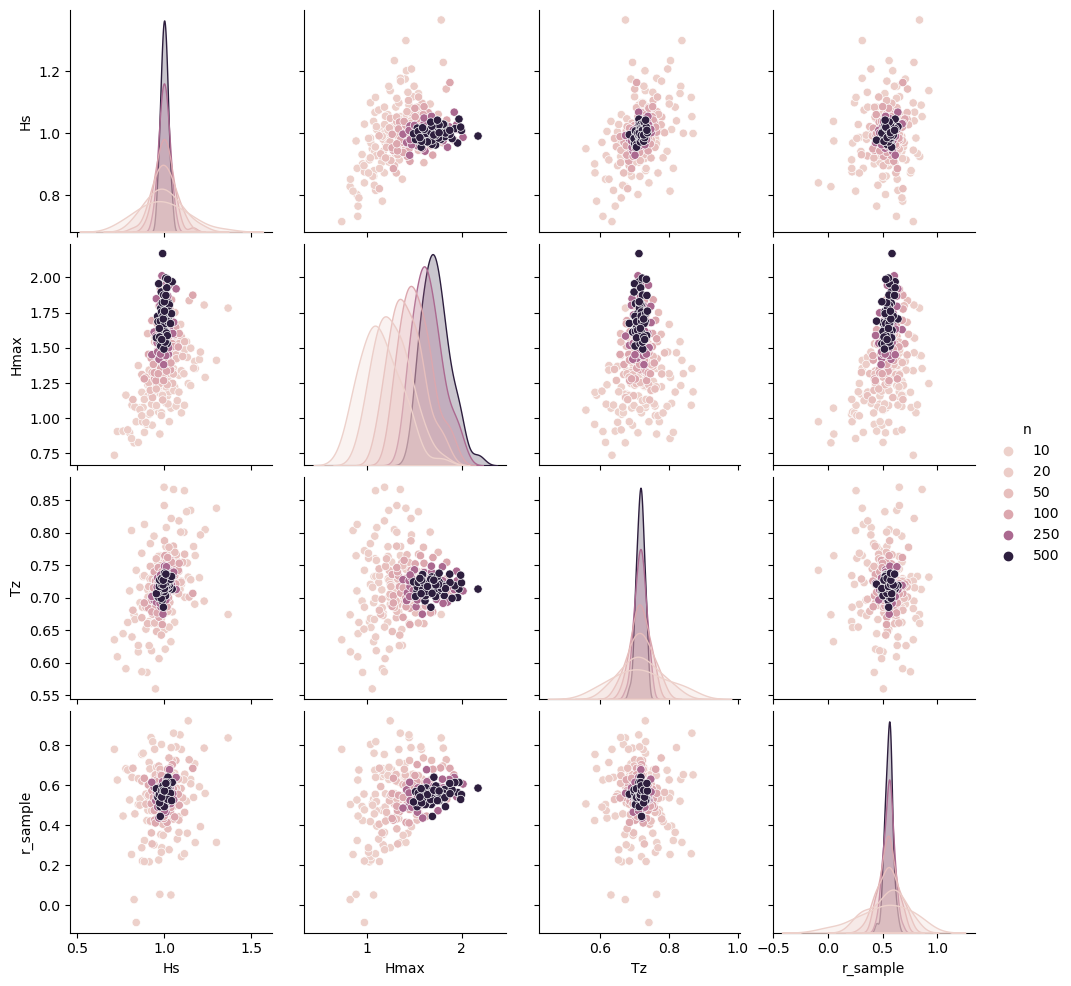

In [8]:
df_stats = seed_stats.sel(gamma=1.0).to_dataframe()[['Hs','Hmax','Tz','r_sample']].reset_index().drop('lhc',axis=1)
sns.pairplot(df_stats,hue='n')

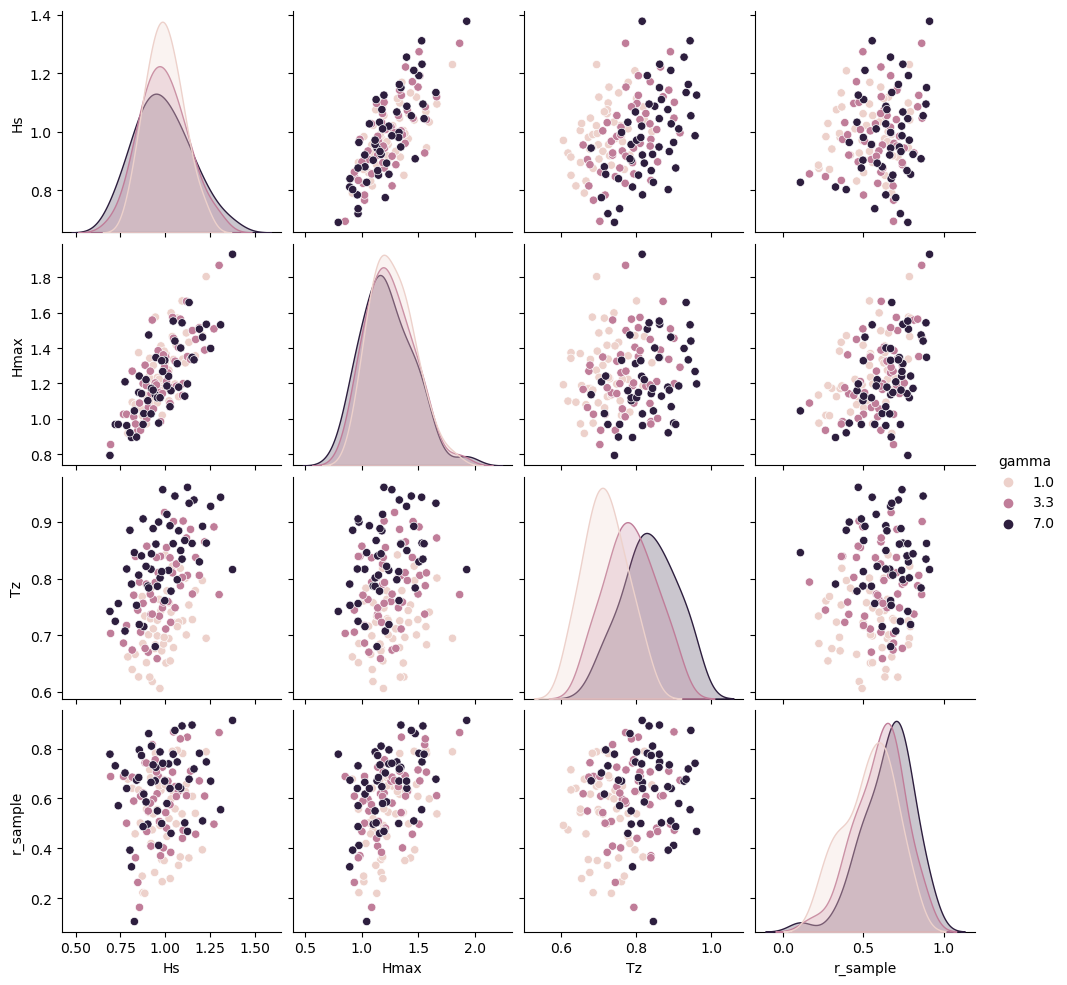

In [9]:
df_stats = seed_stats.sel(n=20).to_dataframe()[['Hs','Hmax','Tz','r_sample']].reset_index().drop('lhc',axis=1)
sns.pairplot(df_stats,hue='gamma')

## Sample a few different hyper cubes with increasing numbers of samples and save the seeds

In [10]:
num_samples = [3**2, 5**2, 7**2] # prime numbers squared

for n_samples in num_samples:
    sampler = qmc.LatinHypercube(d=len(hyper_variables)-1,optimization='random-cd',strength=2)
    sample = sampler.random(n=n_samples)
    print(f'Sample (n={n_samples}) discrepancy {qmc.discrepancy(sample)}')

    ds_lhc = xr.Dataset(pd.DataFrame(sample,columns=[f'{v}' for v in hyper_variables[1:]])).rename({'dim_0':'lhc'})
    
    d_lhc_sample = dask.delayed(lhc_sample)

    all_seeds = []
    for g in ds.gamma:
        for n in ds.n:
            seeds = d_lhc_sample(ds.sel(gamma=g,n=n),ds_lhc)
            all_seeds.append(seeds.expand_dims({'gamma':[g,],'n':[n,]}))

    with ProgressBar():
        results = dask.compute(all_seeds)[0]

    ds_lhc_seeds = xr.merge([ds_lhc,] + results)
    ds_lhc_seeds['seeds'] = ds_lhc_seeds['seeds'].astype(int)
    ds_lhc_seeds = ds_lhc_seeds.assign_coords({k:ds[k] for k in ['fft_min_duration','dt','hs','tp']})

    ds_lhc_seeds.to_netcdf(f'data/seeds/lhc_seeds_n{n_samples}_20230227.nc')

Sample (n=9) discrepancy 0.025612484217350406
[########################################] | 100% Completed | 31.57 s
Sample (n=25) discrepancy 0.0044310074290698775
[########################################] | 100% Completed | 28.18 s
Sample (n=49) discrepancy 0.0017036037584525765
[########################################] | 100% Completed | 26.97 s


# Check the resulting cubes look reasonable, for small n

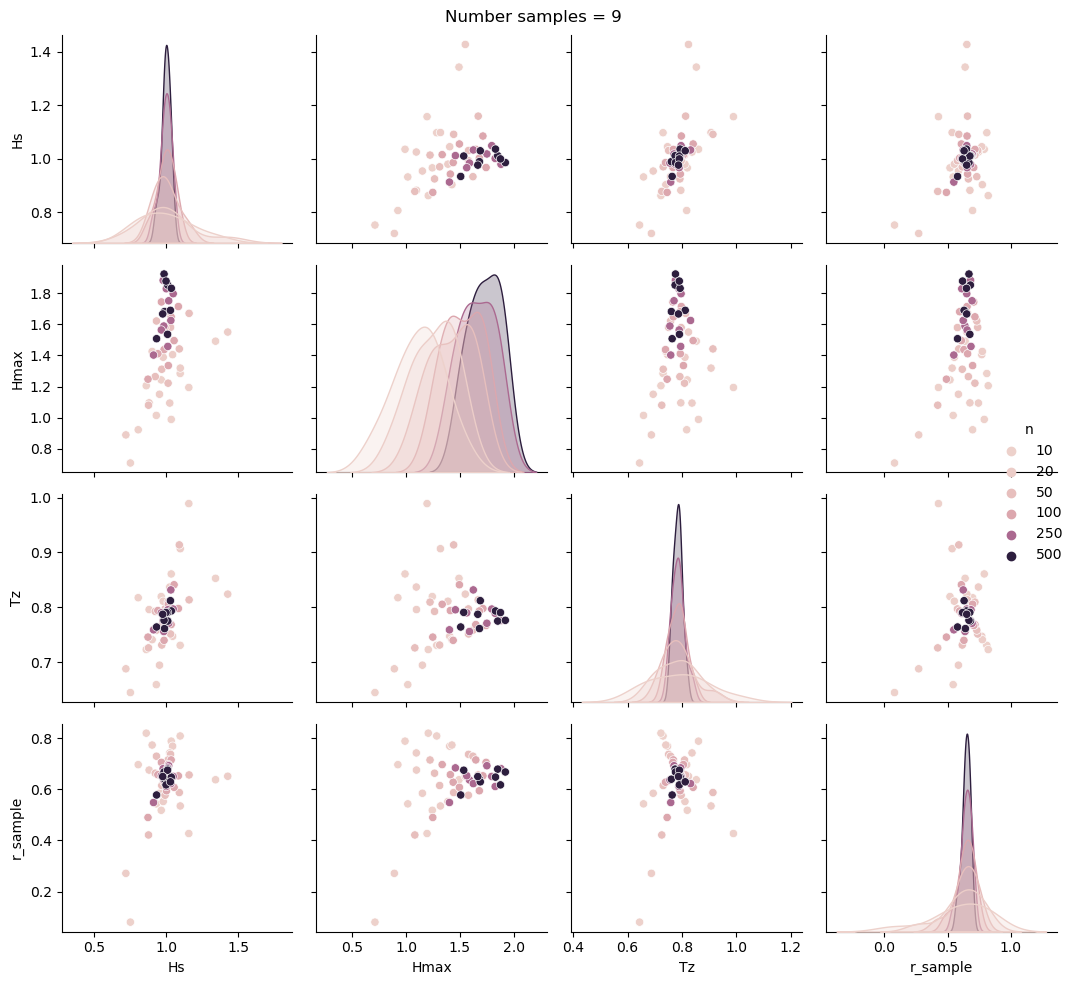

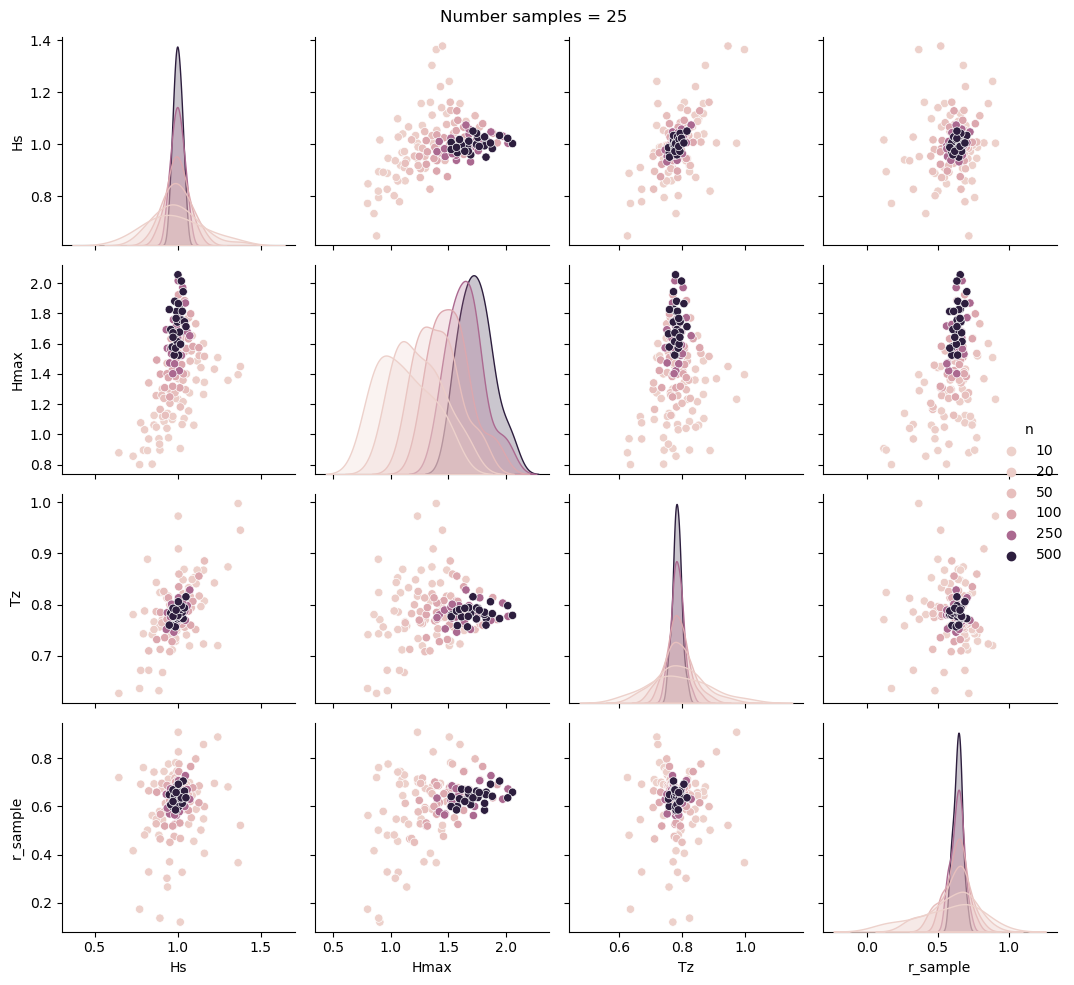

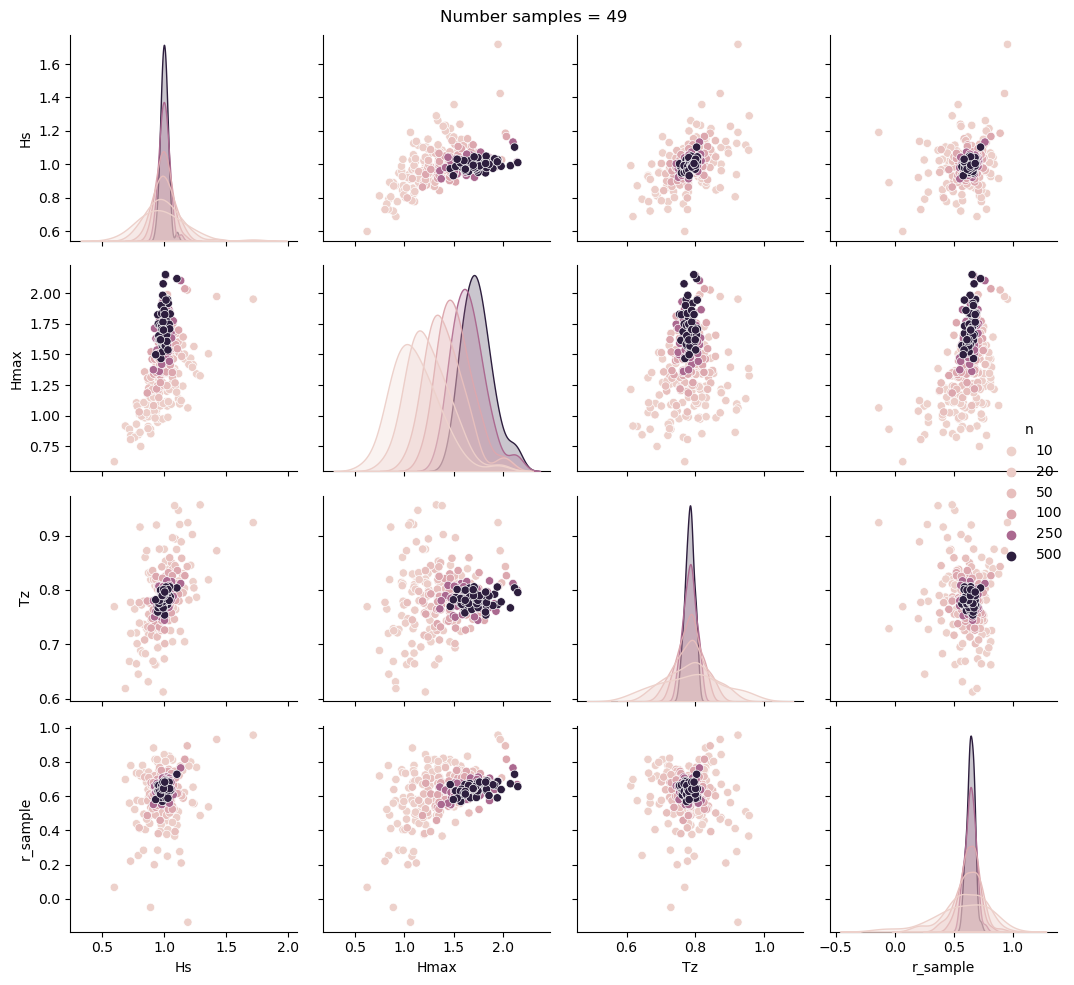

In [11]:
n_samples = 3**2
for n_samples in num_samples:
    ds_lhc_seeds = xr.open_dataset(f'data/seeds/lhc_seeds_n{n_samples}_20230227.nc')
    seed_stats = ls.stats_from_seed(ds_lhc_seeds['seeds'])
    df_stats = seed_stats.sel(gamma=3.3).to_dataframe()[['Hs','Hmax','Tz','r_sample']].reset_index().drop('lhc',axis=1)
    pg=sns.pairplot(df_stats,hue='n')
    pg.fig.suptitle(f'Number samples = {n_samples}')
    pg.fig.tight_layout()
    display(pg)